In [1]:
# attempt again... recreating the paper

# Impact of Array Modes

In [2]:
import numpy as np
import qutip as qt
import scqubits as scq
from dataclasses import dataclass, replace
from typing import Optional, Literal, Dict, Tuple, Sequence

In [3]:
ZPFMode = Literal["linearized", "override"]
# not sure what definition should be used
# can either be the one obtained from harmonic approx or literally computed through the matrix element
# by default we will go with the "linearized" one to match paper

@dataclass(frozen=True)
class FluxoniumArrayCfg:
    # fluxonium params (phi mode)
    EJ: float
    EC: float
    EL: float
    flux: float
    cutoff: int
    num_qbt_states: int

    #parasitic array mode (mu mode); take lowest even mode 
    omega_array: float        #(omega_mu / 2pi) [GHz]
    N_mu_zpf: float
    num_array_modes: int

    #readout drive (take the semiclassical approx)
    omega_r: float #GHz
    g_phi_r: float # GHz
    g_mu_r: float # GHz
    g_phi_mu: float # GHz

    #zero point fluctuation normalization
    Nphi_zpf_mode: ZPFMode = "linearized"
    Nphi_zpf_override: Optional[float] = None

    #need to make sure units is consistent with qutip
    #if true: convert GHz -> (rad / time_unit); if not keep GHz units
    use_angular_units: bool = True


def Nphi_zpf_linearized(cfg: FluxoniumArrayCfg) -> float:
    #paper's zpf_p = (EL/(32 EC))^(1/4)
    return float((cfg.EL / (32.0 * cfg.EC)) ** 0.25)


def get_Nphi_zpf(cfg: FluxoniumArrayCfg) -> float:
    if cfg.Nphi_zpf_mode == "override":
        if cfg.Nphi_zpf_override is None:
            raise ValueError("Nphi_zpf_override is None.")
        return cfg.Nphi_zpf_override
    return Nphi_zpf_linearized(cfg)


def _scale(cfg: FluxoniumArrayCfg) -> float:
    return (2.0 * np.pi) if cfg.use_angular_units else 1.0


# ----------------------------
# Build H0 + operators
# ----------------------------

def build_fluxonium_array(cfg: FluxoniumArrayCfg):
    """
    Builds the semiclassical model in the form used in Eqs. (5)–(6) of the paper:
        H0 = H_phi + H_mu + g_phi_mu * (N_phi/Nphi_zpf)*(N_mu/Nmu_zpf)
        Vsc(nbar) = 2*sqrt(nbar)*[ g_phi_r*(N_phi/Nphi_zpf) + g_mu_r*(N_mu/Nmu_zpf) ]
    with N_mu = -i Nmu_zpf (a - a^†).  (Hermitian)
    """
    # ---- fluxonium eigensystem (scqubits gives energies in GHz) ----
    fluxonium = scq.Fluxonium(
        EJ=cfg.EJ,
        EC=cfg.EC,
        EL=cfg.EL,
        flux=cfg.flux,
        cutoff=cfg.cutoff,
        truncated_dim=cfg.num_qbt_states,
    )
    evals_q, evecs_q = fluxonium.eigensys(evals_count=cfg.num_qbt_states)

    Hq = qt.Qobj(np.diag(evals_q))  # in GHz units

    # N_phi operator in the fluxonium eigenbasis (dimension = num_qbt_states)
    Nphi_mat = fluxonium.n_operator(energy_esys=(evals_q, evecs_q))
    Nphi = qt.Qobj(Nphi_mat)

    # ---- parasitic mode ----
    N_a = cfg.num_array_modes
    a_mu = qt.destroy(N_a)
    n_mu = a_mu.dag() * a_mu

    # IMPORTANT: correct Hermitian parasitic "charge"
    Nmu = -1j * cfg.N_mu_zpf * (a_mu - a_mu.dag())

    Hmu = cfg.omega_array * n_mu  # GHz units (constant 0.5*omega can be omitted)

    # ---- composite space ----
    Iq = qt.qeye(cfg.num_qbt_states)
    Imu = qt.qeye(N_a)

    Hq_full  = qt.tensor(Hq, Imu)
    Hmu_full = qt.tensor(Iq, Hmu)

    Nphi_full = qt.tensor(Nphi, Imu)
    Nmu_full  = qt.tensor(Iq, Nmu)

    # normalized operators used by Eqs (5)-(6)
    Nphi_zpf = get_Nphi_zpf(cfg)
    Xphi = Nphi_full / Nphi_zpf
    Xmu  = Nmu_full / cfg.N_mu_zpf

    # interaction Eq. (5)
    Hint = cfg.g_phi_mu * (Xphi * Xmu)

    H0 = Hq_full + Hmu_full + Hint

    # number operators for plotting (paper uses "excitation index" in the bare fluxonium eigenbasis)
    nq_index = qt.Qobj(np.diag(np.arange(cfg.num_qbt_states)))
    nphi_excitation = qt.tensor(nq_index, Imu)
    nmu_number = qt.tensor(Iq, n_mu)

    # sanity: Hermiticity
    herm_err = (H0 - H0.dag()).norm()
    if herm_err > 1e-9:
        raise ValueError(f"H0 is not Hermitian (norm(H0-H0^†)={herm_err:g}). "
                         f"Check operator definitions (N_mu must be -i(a-a†)).")

    return {
        "H0_GHz": H0,
        "Xphi": Xphi,
        "Xmu": Xmu,
        "nphi_excitation": nphi_excitation,
        "nmu_number": nmu_number,
        "Nphi_zpf": Nphi_zpf,
    }


# ----------------------------
# Drive + Floquet
# ----------------------------

def V_sc_op(cfg: FluxoniumArrayCfg, system, nbar_r: float) -> qt.Qobj:
    """
    Implements Eq. (6) (but without the explicit cos term):
        Vsc(nbar) = 2*sqrt(nbar)*( g_phi_r*Xphi + g_mu_r*Xmu )
    """
    return 2.0 * np.sqrt(nbar_r) * (cfg.g_phi_r * system["Xphi"] + cfg.g_mu_r * system["Xmu"])


def time_dependent_H(cfg: FluxoniumArrayCfg, system, nbar_r: float, omega_d: float):
    """
    Returns QuTiP time-dependent Hamiltonian list and (T, args).

    omega_d is interpreted as (omega_d/2π) in GHz (i.e. frequency in GHz),
    matching how the paper labels ωd/2π on the axis. 
    """
    s = _scale(cfg)
    H0 = s * system["H0_GHz"]
    H1 = s * V_sc_op(cfg, system, nbar_r)

    w = s * omega_d  # either 2π*GHz or GHz, depending on convention
    T = 2.0 * np.pi / w

    def drive(t, args):
        return np.cos(args["w"] * t)

    Ht = [H0, [H1, drive]]
    args = {"w": w}
    return Ht, T, args


def floquet_modes_nbar(cfg: FluxoniumArrayCfg, system, omega_d: float, nbar_r: float):
    """
    Compute Floquet modes at t=0 and quasi-energies using FloquetBasis if available,
    else fall back to qutip.floquet_modes.
    """
    Ht, T, args = time_dependent_H(cfg, system, nbar_r, omega_d)

    # Prefer FloquetBasis (QuTiP 5), fall back if not present
    if hasattr(qt, "FloquetBasis"):
        fb = qt.FloquetBasis(Ht, T, args=args)
        modes = fb.mode(0.0)
        eps = getattr(fb, "e_quasi", None)
        if eps is None:
            # fallback attribute name (just in case)
            eps = getattr(fb, "quasi_energies", None)
        return modes, np.asarray(eps)
    else:
        modes, eps = qt.floquet_modes(Ht, T, args=args)
        return modes, np.asarray(eps)


# ----------------------------
# Branch analysis (Eq. 7)
# ----------------------------

def seed_indices(H0: qt.Qobj,
                 cfg: FluxoniumArrayCfg,
                 k_list=(0, 1, 2),
                 n_mu_seed: int = 0,
                 overlap_warn: float = 0.8):
    """
    Label dressed eigenstates of H0 by max overlap with bare |k>_phi x |n_mu_seed>_mu.
    The paper trusts labels only when overlap > 0.8. 
    """
    evals, evecs = H0.eigenstates()
    N_q = cfg.num_qbt_states
    N_a = cfg.num_array_modes

    seed = {}
    overlaps_best = {}

    for k in k_list:
        bare = qt.tensor(qt.basis(N_q, k), qt.basis(N_a, n_mu_seed))
        overlaps = np.array([abs(bare.overlap(psi))**2 for psi in evecs])
        j = int(np.argmax(overlaps))
        seed[(k, n_mu_seed)] = j
        overlaps_best[(k, n_mu_seed)] = float(overlaps[j])

        if overlaps_best[(k, n_mu_seed)] < overlap_warn:
            print(f"WARNING: seed overlap for {(k,n_mu_seed)} is only {overlaps_best[(k,n_mu_seed)]:.3f} "
                  f"(<{overlap_warn}); labeling may be unreliable.")

    return seed, evecs, np.asarray(evals), overlaps_best


def floquet_branch_analysis(cfg: FluxoniumArrayCfg,
                            system,
                            omega_d: float,
                            nbar_list: Sequence[float],
                            init_k_list=(0, 1, 2),
                            n_mu_seed: int = 0):
    """
    Implements the branch tracking of Eq. (7):
      |i>_l = argmax_m | <i_{l-1} | m_{nbar=l} > |^2
    and records <n_phi> and <n_mu>.
    """
    H0 = system["H0_GHz"]  # scaling irrelevant for eigenvectors
    nphi_exc = system["nphi_excitation"]
    nmu_num  = system["nmu_number"]

    seed, evecs0, evals0, _ = seed_indices(H0, cfg, k_list=init_k_list, n_mu_seed=n_mu_seed)

    branches = {}

    # nbar = 0 -> dressed eigenstate of H0 selected by overlap label
    for k in init_k_list:
        label = (k, n_mu_seed)
        idx0 = seed[label]
        psi0 = evecs0[idx0]
        branches[label] = {
            "states": [psi0],
            "eps": [evals0[idx0]],
            "n_phi": [np.real(qt.expect(nphi_exc, psi0))],
            "n_mu":  [np.real(qt.expect(nmu_num, psi0))],
        }

    # nbar >= 1 -> Floquet tracking
    for nbar in nbar_list[1:]:
        modes, eps = floquet_modes_nbar(cfg, system, omega_d, nbar)

        for label, branch in branches.items():
            psi_prev = branch["states"][-1]
            overlaps = np.array([abs(psi_prev.overlap(psi))**2 for psi in modes])
            j = int(np.argmax(overlaps))
            psi = modes[j]

            branch["states"].append(psi)
            branch["eps"].append(eps[j])
            branch["n_phi"].append(np.real(qt.expect(nphi_exc, psi)))
            branch["n_mu"].append(np.real(qt.expect(nmu_num, psi)))

    # arrays
    for b in branches.values():
        b["eps"] = np.asarray(b["eps"])
        b["n_phi"] = np.asarray(b["n_phi"])
        b["n_mu"] = np.asarray(b["n_mu"])

    return branches


def branch_mapping(cfg: FluxoniumArrayCfg,
                   system,
                   omega_d_list: Sequence[float],
                   nbar_list: Sequence[float],
                   init_k_list=(0, 1, 2),
                   n_mu_seed: int = 0):
    labels = [(k, n_mu_seed) for k in init_k_list]
    shape = (len(omega_d_list), len(nbar_list))

    maps_nphi = {lab: np.zeros(shape) for lab in labels}
    maps_nmu  = {lab: np.zeros(shape) for lab in labels}

    for iw, omega_d in enumerate(omega_d_list):
        print(f"omega_d/2pi = {omega_d:.4f} GHz   ({iw+1}/{len(omega_d_list)})")
        branches = floquet_branch_analysis(cfg, system, omega_d, nbar_list,
                                           init_k_list=init_k_list, n_mu_seed=n_mu_seed)
        for lab in labels:
            maps_nphi[lab][iw, :] = branches[lab]["n_phi"]
            maps_nmu[lab][iw, :]  = branches[lab]["n_mu"]

    return maps_nphi, maps_nmu


In [4]:
def paper_cfg() -> FluxoniumArrayCfg:
    EJ1 = 7.3
    EC_phi = 0.9177436958045079   # Charge1 in their code (fluxonium EC)
    EJJ = 60.0
    N = 122
    EL = EJJ / N                   # ~0.492 (they print ~0.5)

    EC_mu = 0.3032002286433497     # E1 in their code (parasitic EC)
    omega_mu = float(np.sqrt(8.0 * EC_mu * EJJ))  # ~12.06 GHz
    Nmu_zpf  = float(((EJJ/(8.0*EC_mu))**0.25) / np.sqrt(2.0))  # ~1.58

    return FluxoniumArrayCfg(
        EJ=EJ1, EC=EC_phi, EL=EL, flux=0.5,
        cutoff=130, num_qbt_states=20,

        omega_array=omega_mu, N_mu_zpf=Nmu_zpf, num_array_modes=5,

        omega_r=9.0,                # not critical; you scan omega_d anyway
        g_phi_r=0.0255,
        g_mu_r=0.00845,
        g_phi_mu=0.315,

        Nphi_zpf_mode="linearized",  # matches their zpf_p construction
        use_angular_units=True,      # QuTiP-doc convention 
    )


In [4]:
cfg = paper_cfg()
system = build_fluxonium_array(cfg)

omega_d_list = np.linspace(8.5, 9.5, 401)   # GHz (omega_d/2pi)
nbar_list = np.arange(0, 51, 1)

maps_nphi, maps_nmu = branch_mapping(cfg, system, omega_d_list, nbar_list, init_k_list=(0,1,2))

# Then plot similar to plot_three_branches, using maps_nphi and maps_nmu.


omega_d/2pi = 8.5000 GHz   (1/401)


KeyboardInterrupt: 

# Corrections for System Params

In [ ]:
#make sure to use correct parasitic mode coupling:
N_mu = -1j * cfg.N_mu_zpf * (a_mu - a_mu.dag())

#plus, use linearized N_phi_zpf, rather than <0|N_phi^2|0>

In [5]:
# flux sweeps 

def flux_sweep_mapping(cfg: FluxoniumArrayCfg,
                       flux_list: Sequence[float],
                       nbar_list: Sequence[float],
                       omega_d: Optional[float] = None,
                       init_k_list=(0,1,2),
                       n_mu_seed: int = 0):
    if omega_d is None:
        omega_d = cfg.omega_r

    labels = [(k, n_mu_seed) for k in init_k_list]
    shape = (len(flux_list), len(nbar_list))
    maps_nphi = {lab: np.zeros(shape) for lab in labels}
    maps_nmu  = {lab: np.zeros(shape) for lab in labels}

    for iphi, phi_ext in enumerate(flux_list):
        cfg_phi = replace(cfg, flux=float(phi_ext))
        system_phi = build_fluxonium_array(cfg_phi)

        branches = floquet_branch_analysis(cfg_phi, system_phi, omega_d, nbar_list,
                                           init_k_list=init_k_list, n_mu_seed=n_mu_seed)

        for lab in labels:
            maps_nphi[lab][iphi, :] = branches[lab]["n_phi"]
            maps_nmu[lab][iphi, :]  = branches[lab]["n_mu"]

        print(rf"flux={phi_ext:.4f} phi0 ({iphi+1}/{len(flux_list)})")

    return maps_nphi, maps_nmu

#==== Aggron qA ====
# cfg = FluxoniumArrayCfg(
#     EJ=4.167, EC=0.8309, EL=1.203, flux=0.5,
#     cutoff=110, num_qbt_states=20,
#     omega_array=12.06, N_mu_zpf=1.58, num_array_modes=5,
#     omega_r=5.098,
#     g_phi_r=0.026,
#     g_mu_r=0.00845,
#     g_phi_mu=0.315,
#     Nphi_zpf_mode="linearized",
#     use_angular_units=True,
# )


#====Aggron qC====
cfg = FluxoniumArrayCfg(
    EJ = 3.6996,
    EC = 0.8394,
    EL = 1.0376,
    flux = 0.5,
    cutoff= 110, num_qbt_states=25,
    omega_array=12.06, N_mu_zpf = 1.58, num_array_modes=5,
    omega_r=7.327, g_phi_r=0.042, g_mu_r = 0.00845,
    g_phi_mu = 0.315, Nphi_zpf_mode="linearized", use_angular_units=True
)


flux_list = np.linspace(0.465, 0.488, 151)
nbar_list = np.arange(0, 51, 1)
omega_d = cfg.omega_r

maps_nphi_flux, maps_nmu_flux = flux_sweep_mapping(cfg, flux_list, nbar_list, omega_d=omega_d)


flux=0.4650 phi0 (1/151)
flux=0.4652 phi0 (2/151)
flux=0.4653 phi0 (3/151)
flux=0.4655 phi0 (4/151)
flux=0.4656 phi0 (5/151)
flux=0.4658 phi0 (6/151)
flux=0.4659 phi0 (7/151)
flux=0.4661 phi0 (8/151)
flux=0.4662 phi0 (9/151)
flux=0.4664 phi0 (10/151)
flux=0.4665 phi0 (11/151)
flux=0.4667 phi0 (12/151)
flux=0.4668 phi0 (13/151)
flux=0.4670 phi0 (14/151)
flux=0.4671 phi0 (15/151)
flux=0.4673 phi0 (16/151)
flux=0.4675 phi0 (17/151)
flux=0.4676 phi0 (18/151)
flux=0.4678 phi0 (19/151)
flux=0.4679 phi0 (20/151)
flux=0.4681 phi0 (21/151)
flux=0.4682 phi0 (22/151)
flux=0.4684 phi0 (23/151)
flux=0.4685 phi0 (24/151)
flux=0.4687 phi0 (25/151)
flux=0.4688 phi0 (26/151)
flux=0.4690 phi0 (27/151)
flux=0.4691 phi0 (28/151)
flux=0.4693 phi0 (29/151)
flux=0.4694 phi0 (30/151)
flux=0.4696 phi0 (31/151)
flux=0.4698 phi0 (32/151)
flux=0.4699 phi0 (33/151)
flux=0.4701 phi0 (34/151)
flux=0.4702 phi0 (35/151)
flux=0.4704 phi0 (36/151)
flux=0.4705 phi0 (37/151)
flux=0.4707 phi0 (38/151)
flux=0.4708 phi0 (39/

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_flux_scar_maps(flux_list, nbar_list, maps_nq, maps_nmu,labels = ((0,0),(1,0),(2,0)), log_scale = True, savepath = None):
    fig, axes = plt.subplots(2,3, figsize = (10, 6), constrained_layout = True, sharey = True)
    extent = [flux_list[0], flux_list[-1], nbar_list[0], nbar_list[-1]]
    cmaps= ['Reds', 'Greens', 'Blues']
    for col, (lab, cmap) in enumerate(zip(labels, cmaps)):
        nq_plot = maps_nq[lab].T
        nmu_plot = maps_nmu[lab].T

        if log_scale:
            norm = LogNorm(vmin=1e-2, vmax=max(nq_plot.max(), 1e-1))  # set sensible bounds
        else:
            norm = None
        im1 = axes[0, col].imshow(nq_plot, origin = "lower", aspect = "auto", interpolation = "nearest",extent = extent, cmap = cmap, norm=norm)
        axes[0, col].set_title(rf"$\langle n_q \rangle$ branch {lab[0]}")
        if col == 0:
            axes[0, col].set_ylabel(r"$\bar{n}_r$")
        fig.colorbar(im1, ax = axes[0, col], fraction=0.046, pad=0.04)
        im2 = axes[1, col].imshow(nmu_plot, origin = "lower", aspect = "auto", interpolation = "nearest", extent = extent, cmap = cmap, norm=norm)
        axes[1, col].set_title(rf"$\langle n_\mu \rangle$ branch {lab[0]}")
        axes[1, col].set_xlabel(r"$\Phi_{ext} / \Phi_0$")
        if col == 0:
            axes[1, col].set_ylabel(r"$\bar{n}_r$")
        fig.colorbar(im2, ax = axes[1, col], fraction=0.046, pad=0.04)
    if savepath is not None:
        plt.savefig(savepath, dpi=300)
    return fig, axes
log_scale = False
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%I%M%S%p")  # e.g: 20260104_034512PM
savepath = f"fluxonium_array_scar_maps_fluxsweep_qC_{flux_list[0]:.2f}_{flux_list[-1]:.2f}_{timestamp}_logscale={log_scale}.png"

# plot_flux_scar_maps(flux_list, nbar_list, maps_nphi_flux, maps_nmu_flux, log_scale=log_scale, savepath=savepath)

In [16]:
# scan across coupling

def coupling_scan_vs_drive(cfg: FluxoniumArrayCfg,
                           g_phi_mu_list: Sequence[float],
                           omega_d_list: Sequence[float],
                           nbar_list: Sequence[float],
                           init_k_list=(0,1,2),
                           n_mu_seed: int = 0):
    out = {}
    for g in g_phi_mu_list:
        print(f"Scanning g_phi_mu = {g:.4f} GHz")
        cfg_g = replace(cfg, g_phi_mu=float(g))
        system = build_fluxonium_array(cfg_g)
        maps_nphi, maps_nmu = branch_mapping(cfg_g, system, omega_d_list, nbar_list,
                                             init_k_list=init_k_list, n_mu_seed=n_mu_seed)
        out[g] = (maps_nphi, maps_nmu)
        print(f"Completed g_phi_mu = {g:.4f} GHz")
    return out

def coupling_scan_vs_flux(cfg: FluxoniumArrayCfg,
                          g_phi_mu_list: Sequence[float],
                          flux_list: Sequence[float],
                          nbar_list: Sequence[float],
                          init_k_list=(0,1,2),
                        n_mu_seed: int = 0):
    out = {}
    for g in g_phi_mu_list:
        print(f"Scanning g_phi_mu = {g:.4f} GHz")
        cfg_g = replace(cfg, g_phi_mu=float(g))
        maps_nphi, maps_nmu = flux_sweep_mapping(cfg_g, flux_list, nbar_list,
                                                 init_k_list=init_k_list, n_mu_seed=n_mu_seed)
        out[g] = (maps_nphi, maps_nmu)
        print(f"Completed g_phi_mu = {g:.4f} GHz")
    return out

# scan across array mode frequency

def omega_mu_scan_vs_drive(cfg: FluxoniumArrayCfg,
                           omega_mu_list: Sequence[float],
                           omega_d_list: Sequence[float],
                           nbar_list: Sequence[float],
                           init_k_list=(0,1,2),
                           n_mu_seed: int = 0):
    out = {}
    for om in omega_mu_list:
        print(f"Scanning omega_mu = {om:.4f} GHz")
        cfg_m = replace(cfg, omega_array=float(om))
        system = build_fluxonium_array(cfg_m)
        maps_nphi, maps_nmu = branch_mapping(cfg_m, system, omega_d_list, nbar_list,
                                             init_k_list=init_k_list, n_mu_seed=n_mu_seed)
        out[om] = (maps_nphi, maps_nmu)
        print(f"Completed omega_mu = {om:.4f} GHz")
    return out

def omega_mu_scan_vs_flux(cfg: FluxoniumArrayCfg,
                        omega_mu_list: Sequence[float],
                        flux_list: Sequence[float],
                        nbar_list: Sequence[float],
                        init_k_list=(0,1,2),
                        n_mu_seed: int = 0):
    out = {}
    for om in omega_mu_list:
        print(f"Scanning omega_mu = {om:.4f} GHz")
        cfg_m = replace(cfg, omega_array=float(om))
        maps_nphi, maps_nmu = flux_sweep_mapping(cfg_m, flux_list, nbar_list,
                                                 init_k_list=init_k_list, n_mu_seed=n_mu_seed)
        out[om] = (maps_nphi, maps_nmu)
        print(f"Completed omega_mu = {om:.4f} GHz")
    return out

def save_scan_data(scan_result: dict, 
                   scan_type: str,  # "coupling" or "omega_mu"
                   cfg: FluxoniumArrayCfg,
                   omega_d_list: Sequence[float],
                   nbar_list: Sequence[float],
                   timestamp: str = None,
                   save_dir: str = ".",
                   extra_label: str = ""):
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    param_values = list(scan_result.keys())
    param_range = f"{min(param_values):.3f}to{max(param_values):.3f}"
    drive_range = f"drive{omega_d_list[0]:.2f}to{omega_d_list[-1]:.2f}"
    nbar_range = f"nbar{nbar_list[0]}to{nbar_list[-1]}"
    
    if scan_type == "coupling":
        filename = f"coupling_scan_g_phi_mu={param_range}_{drive_range}_{nbar_range}_{timestamp}"
    elif scan_type == "omega_mu":
        filename = f"omega_mu_scan={param_range}_{drive_range}_{nbar_range}_{timestamp}"
    else:
        filename = f"{scan_type}_scan={param_range}_{drive_range}_{nbar_range}_{timestamp}"
    
    if extra_label:
        filename = f"{extra_label}_{filename}"
    
    # Package all relevant data
    save_dict = {
        "scan_result": scan_result,
        "scan_type": scan_type,
        "omega_d_list": np.array(omega_d_list),
        "nbar_list": np.array(nbar_list),
        "param_values": param_values,
        "cfg": cfg,  # dataclass should pickle fine
        "timestamp": timestamp,
    }
    
    filepath = Path(save_dir) / f"{filename}.pkl"
    with open(filepath, "wb") as f:
        pickle.dump(save_dict, f)
    
    print(f"Saved scan data to: {filepath}")
    return filepath


def load_scan_data(filepath: str):
    """Load previously saved scan data."""
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    print(f"Loaded {data['scan_type']} scan with {len(data['param_values'])} parameter values")
    return data



In [8]:
flux_list = np.linspace(0.465, 0.488, 31)
nbar_list = np.arange(0, 51, 1)

In [11]:
#scan different coupling strengths between fluxonium and parasitic mode
g_mu_phi = [0.5, 0.7, 1.0] #units = hertz
# omega_d_list = np.linspace(5,6, 101)
nbar_list = np.arange(0, 51, 1)
coupling_scan_res = coupling_scan_vs_flux(cfg, g_mu_phi, flux_list, nbar_list)

Scanning g_phi_mu = 0.5000 GHz
flux=0.4650 phi0 (1/31)
flux=0.4658 phi0 (2/31)
flux=0.4665 phi0 (3/31)
flux=0.4673 phi0 (4/31)
flux=0.4681 phi0 (5/31)
flux=0.4688 phi0 (6/31)
flux=0.4696 phi0 (7/31)
flux=0.4704 phi0 (8/31)
flux=0.4711 phi0 (9/31)
flux=0.4719 phi0 (10/31)
flux=0.4727 phi0 (11/31)
flux=0.4734 phi0 (12/31)
flux=0.4742 phi0 (13/31)
flux=0.4750 phi0 (14/31)
flux=0.4757 phi0 (15/31)
flux=0.4765 phi0 (16/31)
flux=0.4773 phi0 (17/31)
flux=0.4780 phi0 (18/31)
flux=0.4788 phi0 (19/31)
flux=0.4796 phi0 (20/31)
flux=0.4803 phi0 (21/31)
flux=0.4811 phi0 (22/31)
flux=0.4819 phi0 (23/31)
flux=0.4826 phi0 (24/31)
flux=0.4834 phi0 (25/31)
flux=0.4842 phi0 (26/31)
flux=0.4849 phi0 (27/31)
flux=0.4857 phi0 (28/31)
flux=0.4865 phi0 (29/31)
flux=0.4872 phi0 (30/31)
flux=0.4880 phi0 (31/31)
Completed g_phi_mu = 0.5000 GHz
Scanning g_phi_mu = 0.7000 GHz
flux=0.4650 phi0 (1/31)
flux=0.4658 phi0 (2/31)
flux=0.4665 phi0 (3/31)
flux=0.4673 phi0 (4/31)
flux=0.4681 phi0 (5/31)
flux=0.4688 phi0 (6/

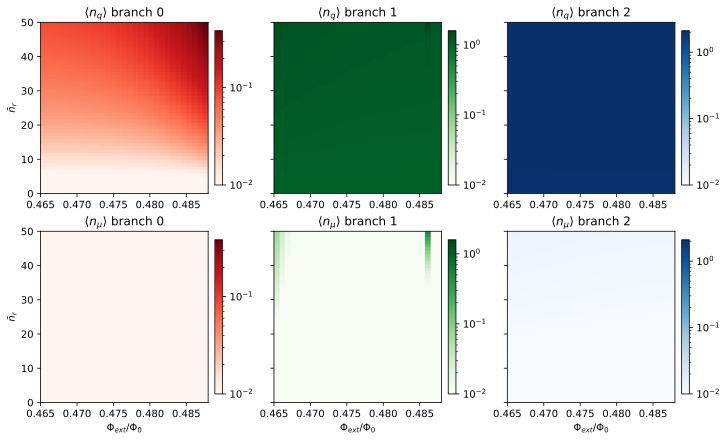

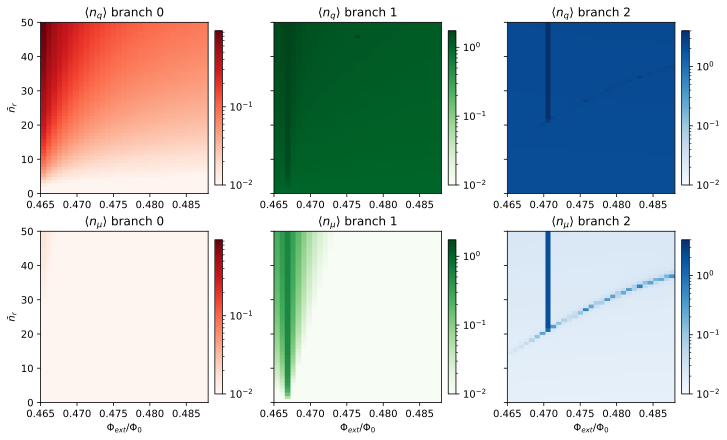

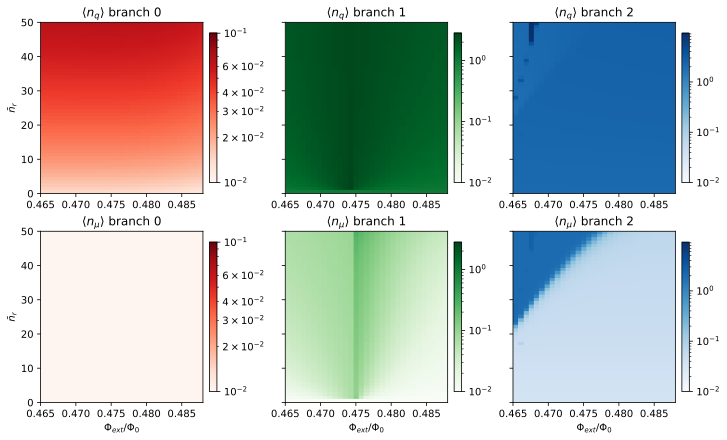

In [31]:
for g, (maps_nphi, maps_nmu) in coupling_scan_res.items():
    timestamp = datetime.now().strftime("%Y%m%d_%I%M%S%p")  # e.g: 20260104 _034512PM
    savepath = f"qC_fluxonium_array_scar_maps_fluxsweep_gphi_mu_{g:.2f}_{timestamp}_log.png"
    plot_flux_scar_maps(flux_list, nbar_list, maps_nphi, maps_nmu, log_scale=True, savepath=savepath)

In [ ]:
flux_list = np.linspace(0.465, 0.488, 101)
nbar_list = np.arange(0, 51, 1)
g_mu_phi = [0.7] 
coupling_scan_700MHz = coupling_scan_vs_flux(cfg, g_mu_phi, flux_list, nbar_list)

Scanning g_phi_mu = 0.7000 GHz
flux=0.4650 phi0 (1/101)
flux=0.4652 phi0 (2/101)
flux=0.4655 phi0 (3/101)
flux=0.4657 phi0 (4/101)
flux=0.4659 phi0 (5/101)
flux=0.4662 phi0 (6/101)
flux=0.4664 phi0 (7/101)
flux=0.4666 phi0 (8/101)
flux=0.4668 phi0 (9/101)
flux=0.4671 phi0 (10/101)
flux=0.4673 phi0 (11/101)
flux=0.4675 phi0 (12/101)
flux=0.4678 phi0 (13/101)
flux=0.4680 phi0 (14/101)
flux=0.4682 phi0 (15/101)
flux=0.4685 phi0 (16/101)
flux=0.4687 phi0 (17/101)
flux=0.4689 phi0 (18/101)
flux=0.4691 phi0 (19/101)
flux=0.4694 phi0 (20/101)
flux=0.4696 phi0 (21/101)
flux=0.4698 phi0 (22/101)
flux=0.4701 phi0 (23/101)
flux=0.4703 phi0 (24/101)
flux=0.4705 phi0 (25/101)
flux=0.4708 phi0 (26/101)
flux=0.4710 phi0 (27/101)
flux=0.4712 phi0 (28/101)
flux=0.4714 phi0 (29/101)
flux=0.4717 phi0 (30/101)
flux=0.4719 phi0 (31/101)
flux=0.4721 phi0 (32/101)
flux=0.4724 phi0 (33/101)
flux=0.4726 phi0 (34/101)
flux=0.4728 phi0 (35/101)
flux=0.4731 phi0 (36/101)
flux=0.4733 phi0 (37/101)
flux=0.4735 phi0

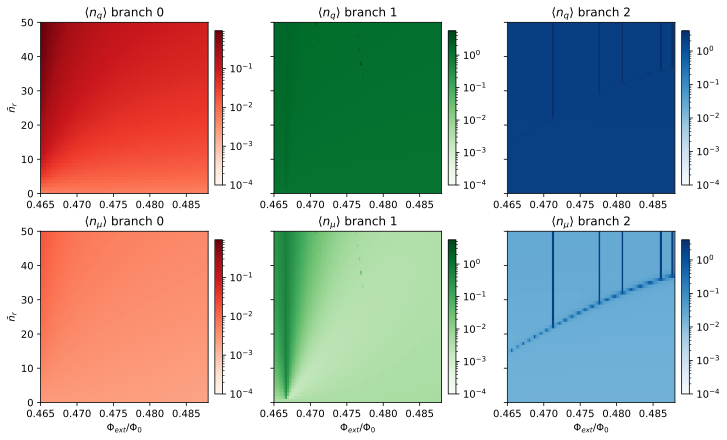

In [29]:
for g, (maps_nphi, maps_nmu) in coupling_scan_700MHz.items():
    timestamp = datetime.now().strftime("%Y%m%d_%I%M%S%p")  # e.g: 20260104 _034512PM
    savepath = f"qC_fluxonium_array_scar_maps_fluxsweep_gphi_mu_{g:.2f}_{timestamp}.png"
    plot_flux_scar_maps(flux_list, nbar_list, maps_nphi, maps_nmu, log_scale=True, savepath=savepath)

In [34]:
omega_mu_list = [7.5]
flux_list = np.linspace(0.465, 0.488, 51)
omega_mu_flx_scan_C = omega_mu_scan_vs_flux(cfg, omega_mu_list, flux_list, nbar_list)
save_scan_data(omega_mu_flx_scan_C, "omega_mu", cfg, omega_d_list=[cfg.omega_r], nbar_list=nbar_list, extra_label="qC")

Scanning omega_mu = 7.5000 GHz
flux=0.4650 phi0 (1/51)
flux=0.4655 phi0 (2/51)
flux=0.4659 phi0 (3/51)
flux=0.4664 phi0 (4/51)
flux=0.4668 phi0 (5/51)
flux=0.4673 phi0 (6/51)
flux=0.4678 phi0 (7/51)
flux=0.4682 phi0 (8/51)
flux=0.4687 phi0 (9/51)
flux=0.4691 phi0 (10/51)
flux=0.4696 phi0 (11/51)
flux=0.4701 phi0 (12/51)
flux=0.4705 phi0 (13/51)
flux=0.4710 phi0 (14/51)
flux=0.4714 phi0 (15/51)
flux=0.4719 phi0 (16/51)
flux=0.4724 phi0 (17/51)
flux=0.4728 phi0 (18/51)
flux=0.4733 phi0 (19/51)
flux=0.4737 phi0 (20/51)
flux=0.4742 phi0 (21/51)
flux=0.4747 phi0 (22/51)
flux=0.4751 phi0 (23/51)
flux=0.4756 phi0 (24/51)
flux=0.4760 phi0 (25/51)
flux=0.4765 phi0 (26/51)
flux=0.4770 phi0 (27/51)
flux=0.4774 phi0 (28/51)
flux=0.4779 phi0 (29/51)
flux=0.4783 phi0 (30/51)
flux=0.4788 phi0 (31/51)
flux=0.4793 phi0 (32/51)
flux=0.4797 phi0 (33/51)
flux=0.4802 phi0 (34/51)
flux=0.4806 phi0 (35/51)
flux=0.4811 phi0 (36/51)
flux=0.4816 phi0 (37/51)
flux=0.4820 phi0 (38/51)
flux=0.4825 phi0 (39/51)
flu

WindowsPath('qC_omega_mu_scan=7.500to7.500_drive7.33to7.33_nbar0to50_20260115_025136.pkl')

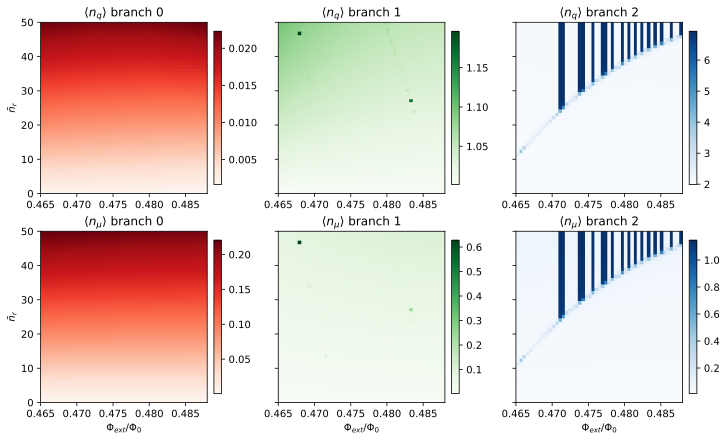

In [35]:
for omega, (maps_nphi, maps_nmu) in omega_mu_flx_scan_C.items():
    timestamp = datetime.now().strftime("%Y%m%d_%I%M%S%p")  # e.g: 20260104 _034512PM
    savepath = f"qC_fluxonium_array_scar_maps_fluxsweep_omega_mu_{omega:.2f}_{timestamp}.png"
    plot_flux_scar_maps(flux_list, nbar_list, maps_nphi, maps_nmu, log_scale=False, savepath=savepath)

In [27]:
import datetime as datetime
import matplotlib.pyplot as plt
def plot_three_branches(omega_d_list, nbar_list, maps_nq, maps_nmu, name, coupling, logscale = True,
                        labels=((0, 0), (1, 0), (2, 0))):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%I%M%S%p")  # e.g: 20260104_034512PM
    

    fig, axes = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)

    extent = [omega_d_list[0], omega_d_list[-1],
              nbar_list[0],    nbar_list[-1]]
    cmaps = ["Reds", "Greens", "Blues"] 
    for col, (label, cmap) in enumerate(zip(labels, cmaps)):
        nq = maps_nq[label].T
        nmu = maps_nmu[label].T
        if logscale:
            nq_plot = np.log10(nq + 1e-3)
            nmu_plot = np.log10(nmu + 1e-3)
        else:
            nq_plot = nq
            nmu_plot = nmu
        ax1 = axes[0, col]
        im1 = axes[0, col].imshow(nq_plot, 
                                  origin = "lower", 
                                  aspect = "auto", 
                                  interpolation = "nearest",
                                  extent = extent, 
                                  cmap = cmap)
        if col == 0:
            ax1.set_ylabel(r"$\bar n_r$")
        ax1.set_title(r"$\langle N_q\rangle$  branch {}".format(label[0]))
        # only put x label on bottom row to avoid clutter

        cbar1 = fig.colorbar(im1, ax=ax1,
                             fraction=0.046, pad=0.04)
        cbar1.set_label(r"$\log_{10}\langle N_q\rangle$")

        # --- bottom row: <n_mu> ---
        ax2 = axes[1, col]
        im2 = ax2.imshow(nmu_plot,
                         origin="lower",
                         aspect="auto",
                         extent=extent,
                         interpolation="nearest", 
                         cmap=cmap)
        ax2.set_xlabel(r"$\omega_d/(2\pi)$ [GHz]")
        if col == 0:
            ax2.set_ylabel(r"$\bar n_r$")

        cbar2 = fig.colorbar(im2, ax=ax2,
                             fraction=0.046, pad=0.04)
        cbar2.set_label(r"$\log_{10}\langle n_\mu\rangle$")
    if not logscale:
        plt.savefig(f"coupling_scan_{name}_coupling={coupling:.3f}GHz_linear_{timestamp}_drive_sweep{omega_d_list[0]:.2f}_{omega_d_list[-1]:.2f}.png", dpi=300)
    else:
        plt.savefig(f"coupling_scan_{name}_fluxonium_array_scar_maps_qA_drivesweep{omega_d_list[0]:.2f}_{omega_d_list[-1]:.2f}_logscale_{timestamp}_coupling={coupling}.png", dpi=300)
    return fig, axes

In [ ]:
# coupling0 = g_mu_phi[3]
# plot_three_branches(omega_d_list, nbar_list, 
#                      coupling_scan_res[coupling0][0], 
#                      coupling_scan_res[coupling0][1], 
#                      name="qA", coupling=coupling0, logscale = False)

NameError: name 'g_mu_phi' is not defined

# Branch Analysis

In [36]:
def _scale(cfg: FluxoniumArrayCfg) -> float:
    return (2.0 * np.pi) if cfg.use_angular_units else 1.0

def to_GHz(cfg: FluxoniumArrayCfg, x: np.ndarray) -> np.ndarray:
    """convert angular units back to GHz if use_angular_units=True."""
    return np.asarray(x) / _scale(cfg)

def wrap_quasienergy(eps: np.ndarray, w: float, centered: bool = True) -> np.ndarray:
    """ 
    centered=True -> [-w/2, w/2)
    centered=False -> [0, w)
    """
    eps = np.asarray(eps)
    if centered:
        return ((eps + 0.5*w) % w) - 0.5*w
    return eps % w

def dominant_product_label(psi: qt.Qobj, N_q: int, N_mu: int, topk: int = 3):
    """
    label psi by overlaps with the bare product basis
      |k_phi> x  |n_mu>,  k=0..N_q-1, n=0..N_mu-1
    """
    results = []
    for k in range(N_q):
        for n in range(N_mu):
            bare = qt.tensor(qt.basis(N_q, k), qt.basis(N_mu, n))
            p = abs(bare.overlap(psi))**2
            results.append(((k, n), float(p)))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:topk]

def floquet_branch_analysis_verbose(
    cfg: FluxoniumArrayCfg,
    system: dict,
    omega_d: float,
    nbar_list,
    init_k: int,
    n_mu_seed: int = 0,
):
    """
    Track ONE branch starting from label (init_k, n_mu_seed), and also store
    the 2nd-best overlap Floquet mode at each step (the "competitor" involved in swaps).

    Returns dict with arrays over nbar_list:
      - psi_best, psi_comp (lists of kets; comp can be None at nbar=0)
      - eps_best, eps_comp
      - ov_best, ov_comp (overlap^2 vs previous best)
      - n_phi_best, n_mu_best
      - n_phi_comp, n_mu_comp
      - label_best, label_comp   (dominant (k,n) from bare product basis)
      - label_prob_best, label_prob_comp (dominant prob)
    """
    H0 = system["H0_GHz"]
    nphi_exc = system["nphi_excitation"]
    nmu_num  = system["nmu_number"]

    # Seed using dressed eigenstates of H0 labeled by overlap with |k,n_mu_seed>
    seed, evecs0, evals0, _ = seed_indices(H0, cfg, k_list=(init_k,), n_mu_seed=n_mu_seed)
    idx0 = seed[(init_k, n_mu_seed)]
    psi0 = evecs0[idx0]

    # Make eps consistent units
    s = _scale(cfg)
    w = s * omega_d

    out = {
        "nbar": np.asarray(nbar_list, dtype=float),
        "psi_best": [psi0],
        "psi_comp": [None],
        "eps_best": [s * float(evals0[idx0])],
        "eps_comp": [np.nan],
        "ov_best": [1.0],
        "ov_comp": [0.0],
        "n_phi_best": [float(np.real(qt.expect(nphi_exc, psi0)))],
        "n_mu_best":  [float(np.real(qt.expect(nmu_num,  psi0)))],
        "n_phi_comp": [np.nan],
        "n_mu_comp":  [np.nan],
        "label_best": [dominant_product_label(psi0, cfg.num_qbt_states, cfg.num_array_modes, topk=1)[0][0]],
        "label_prob_best": [dominant_product_label(psi0, cfg.num_qbt_states, cfg.num_array_modes, topk=1)[0][1]],
        "label_comp": [None],
        "label_prob_comp": [np.nan],
        "omega_d_ang": w,
    }

    psi_prev = psi0
    for nbar in nbar_list[1:]:
        modes, eps = floquet_modes_nbar(cfg, system, omega_d, float(nbar))

        overlaps = np.array([abs(psi_prev.overlap(m))**2 for m in modes])
        order = np.argsort(overlaps)[::-1]
        j1 = int(order[0])
        j2 = int(order[1]) if len(order) > 1 else None

        psi1 = modes[j1]
        eps1 = eps[j1]
        ov1  = float(overlaps[j1])

        if j2 is not None:
            psi2 = modes[j2]
            eps2 = eps[j2]
            ov2  = float(overlaps[j2])
            nphi2 = float(np.real(qt.expect(nphi_exc, psi2)))
            nmu2  = float(np.real(qt.expect(nmu_num,  psi2)))
            lab2, p2 = dominant_product_label(psi2, cfg.num_qbt_states, cfg.num_array_modes, topk=1)[0]
        else:
            psi2, eps2, ov2, nphi2, nmu2, lab2, p2 = None, np.nan, 0.0, np.nan, np.nan, None, np.nan

        nphi1 = float(np.real(qt.expect(nphi_exc, psi1)))
        nmu1  = float(np.real(qt.expect(nmu_num,  psi1)))
        lab1, p1 = dominant_product_label(psi1, cfg.num_qbt_states, cfg.num_array_modes, topk=1)[0]

        out["psi_best"].append(psi1)
        out["psi_comp"].append(psi2)

        out["eps_best"].append(float(eps1))
        out["eps_comp"].append(float(eps2))
        out["ov_best"].append(ov1)
        out["ov_comp"].append(ov2)

        out["n_phi_best"].append(nphi1)
        out["n_mu_best"].append(nmu1)
        out["n_phi_comp"].append(nphi2)
        out["n_mu_comp"].append(nmu2)

        out["label_best"].append(lab1)
        out["label_prob_best"].append(float(p1))
        out["label_comp"].append(lab2)
        out["label_prob_comp"].append(float(p2))

        psi_prev = psi1

    # convert to arrays
    for k in ["eps_best","eps_comp","ov_best","ov_comp","n_phi_best","n_mu_best","n_phi_comp","n_mu_comp",
              "label_prob_best","label_prob_comp"]:
        out[k] = np.asarray(out[k])

    # wrap quasi energies for cleaner plots
    out["eps_best_wrapped"] = wrap_quasienergy(out["eps_best"], w, centered=True)
    out["eps_comp_wrapped"] = wrap_quasienergy(out["eps_comp"], w, centered=True)

    return out

def detect_joint_jump_events(branch_verbose: dict,
                             dphi_min: float = 0.75,
                             dmu_min: float = 0.10):
    """
    Return a list of detected events at steps where both n_phi and n_mu jump.
    Thresholds are in *absolute* expectation value changes between consecutive nbar steps.
    """
    nbar = branch_verbose["nbar"]
    nphi = branch_verbose["n_phi_best"]
    nmu  = branch_verbose["n_mu_best"]

    dnphi = np.diff(nphi)
    dnmu  = np.diff(nmu)

    hits = np.where((np.abs(dnphi) >= dphi_min) & (np.abs(dnmu) >= dmu_min))[0]  # index for "before"
    events = []
    for i in hits:
        ev = {
            "step_before": int(i),
            "step_after":  int(i+1),
            "nbar_before": float(nbar[i]),
            "nbar_after":  float(nbar[i+1]),
            "d_nphi": float(dnphi[i]),
            "d_nmu":  float(dnmu[i]),
            "label_before": branch_verbose["label_best"][i],
            "label_after":  branch_verbose["label_best"][i+1],
            "label_prob_before": float(branch_verbose["label_prob_best"][i]),
            "label_prob_after":  float(branch_verbose["label_prob_best"][i+1]),
            "eps_before_wrapped": float(branch_verbose["eps_best_wrapped"][i]),
            "eps_after_wrapped":  float(branch_verbose["eps_best_wrapped"][i+1]),
        }
        events.append(ev)
    return events

def plot_branch_swap_diagnostics(cfg: FluxoniumArrayCfg,
                                 branch_verbose: dict,
                                 omega_d: float,
                                 title_prefix: str = "",
                                 show_competitor: bool = True,
                                 dphi_min: float = 0.75,
                                 dmu_min: float = 0.10):
    nbar = branch_verbose["nbar"]

    # Convert quasi-energies to GHz for plotting
    eps_b = to_GHz(cfg, branch_verbose["eps_best_wrapped"])
    eps_c = to_GHz(cfg, branch_verbose["eps_comp_wrapped"])

    nphi_b = branch_verbose["n_phi_best"]
    nmu_b  = branch_verbose["n_mu_best"]
    ov_b   = branch_verbose["ov_best"]
    ov_c   = branch_verbose["ov_comp"]

    events = detect_joint_jump_events(branch_verbose, dphi_min=dphi_min, dmu_min=dmu_min)

    fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True, constrained_layout=True)

    # --- panel 1: excitations ---
    ax[0].plot(nbar, nphi_b, "-o", ms=3, label=r"$\langle n_\phi\rangle$ (tracked)")
    ax[0].plot(nbar, nmu_b,  "-o", ms=3, label=r"$\langle n_\mu\rangle$ (tracked)")
    if show_competitor:
        ax[0].plot(nbar, branch_verbose["n_phi_comp"], "--", lw=1.5, label=r"$\langle n_\phi\rangle$ (competitor)")
        ax[0].plot(nbar, branch_verbose["n_mu_comp"],  "--", lw=1.5, label=r"$\langle n_\mu\rangle$ (competitor)")
    ax[0].set_ylabel("excitation")
    ax[0].legend(loc="best")

    # mark events
    for ev in events:
        ax[0].axvline(ev["nbar_after"], ls=":", lw=1)
        ax[0].text(ev["nbar_after"], ax[0].get_ylim()[1]*0.95,
                   f"{ev['label_before']}→{ev['label_after']}",
                   rotation=90, va="top", ha="right", fontsize=8)

    # --- panel 2: quasi energies ---
    ax[1].plot(nbar, eps_b, "-o", ms=3, label="tracked")
    if show_competitor:
        ax[1].plot(nbar, eps_c, "--", lw=1.5, label="competitor")
    ax[1].set_ylabel(r"$\epsilon \ \mathrm{mod}\ \omega_d$ [GHz]")
    ax[1].legend(loc="best")

    # --- panel 3: overlap strengths ---
    ax[2].plot(nbar, ov_b, "-o", ms=3, label=r"$|\langle \psi_{l-1}|\psi_l\rangle|^2$ (best)")
    if show_competitor:
        ax[2].plot(nbar, ov_c, "--", lw=1.5, label="2nd best overlap")
    ax[2].set_ylabel("overlap")
    ax[2].set_xlabel(r"$\bar n_r$")
    ax[2].legend(loc="best")

    fig.suptitle(f"{title_prefix}  ωd/(2π)={omega_d:.4f} GHz", y=1.02)
    return fig, ax, events

def floquet_spectrum_vs_nbar(cfg: FluxoniumArrayCfg,
                            system: dict,
                            omega_d: float,
                            nbar_list,
                            color_by: str = "n_mu",
                            wrap_centered: bool = True):
    """
    For each nbar, compute all Floquet modes and plot eps(mod ωd) vs nbar as a scatter.
    color_by: "n_mu" or "n_phi"
    """
    nphi_exc = system["nphi_excitation"]
    nmu_num  = system["nmu_number"]

    s = _scale(cfg)
    w = s * omega_d

    xs = []
    ys = []
    cs = []

    for nbar in nbar_list:
        modes, eps = floquet_modes_nbar(cfg, system, omega_d, float(nbar))
        epsw = wrap_quasienergy(eps, w, centered=wrap_centered)
        epsw_GHz = to_GHz(cfg, epsw)

        for m, e in zip(modes, epsw_GHz):
            xs.append(float(nbar))
            ys.append(float(e))
            if color_by == "n_phi":
                cs.append(float(np.real(qt.expect(nphi_exc, m))))
            else:
                cs.append(float(np.real(qt.expect(nmu_num, m))))

    fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
    sc = ax.scatter(xs, ys, c=cs, s=10)
    ax.set_xlabel(r"$\bar n_r$")
    ax.set_ylabel(r"$\epsilon \ \mathrm{mod}\ \omega_d$ [GHz]")
    ax.set_title(f"Floquet spectrum vs nbar  (ωd/(2π)={omega_d:.4f} GHz), colored by ⟨{color_by}⟩")
    plt.colorbar(sc, ax=ax, label=f"⟨{color_by}⟩")
    return fig, ax

def find_named_transition(events, from_label=None, to_label=None, allow_reverse=True):
    """
    Filter detected events by (from_label -> to_label).
    If allow_reverse=True, also match reversed order.
    """
    out = []
    for ev in events:
        a = ev["label_before"]
        b = ev["label_after"]
        if from_label is not None and to_label is not None:
            if (a == from_label and b == to_label) or (allow_reverse and a == to_label and b == from_label):
                out.append(ev)
        else:
            out.append(ev)
    return out


In [44]:
cfg = FluxoniumArrayCfg(
    EJ = 3.6996,
    EC = 0.8394,
    EL = 1.0376,
    flux = 0.472,
    cutoff= 110, num_qbt_states=25,
    omega_array=16.06, N_mu_zpf = 1.58, num_array_modes=5,
    omega_r=7.327, g_phi_r=0.042, g_mu_r = 0.00845,
    g_phi_mu = 0.315, Nphi_zpf_mode="linearized", use_angular_units=True
)


flux_list = np.linspace(0.465, 0.488, 151)
nbar_list = np.arange(0, 51, 1)
omega_d = cfg.omega_r

system = build_fluxonium_array(cfg)
branch_v = floquet_branch_analysis_verbose(cfg, system, omega_d, nbar_list, init_k=0, n_mu_seed=0)


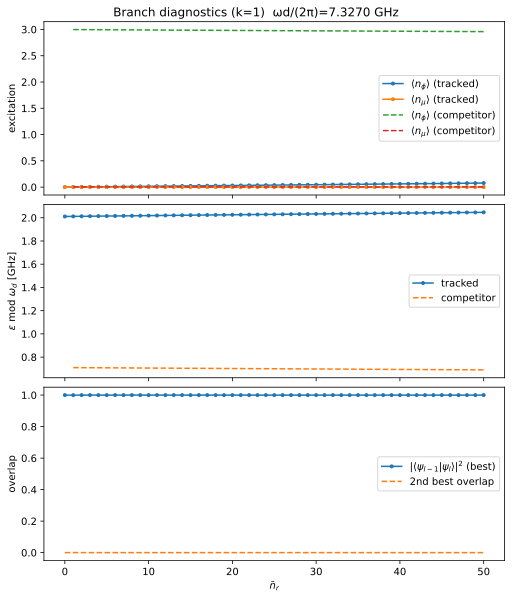

In [45]:
fig, ax, events = plot_branch_swap_diagnostics(
    cfg, branch_v, omega_d,
    title_prefix="Branch diagnostics (k=1)",
    show_competitor=True,
    dphi_min=0.75,
    dmu_min=0.10
)
plt.show()

In [46]:
print("Detected joint-jump (PMIST-like) events:")
for ev in events:
    print(ev)


Detected joint-jump (PMIST-like) events:
